### A program for selecting PS pixels in multi-temporal InSAR

### Input: A stack of interferograms in .mat format (exported from WabInSAR software developed by Manoochehr Shirzaei). WabInSAR software is open access and can be downloaded from the following link:
### https://sites.google.com/vt.edu/eadar-lab/software



### The interferograms are first divided into image patches of 100 by 100 pixels and then fed to the network

### Output: A map with labels 0 and 1, 0 denoting non-PS pixels, and 1 denoting PS pixels 



### Loading essential libraries

In [1]:
import numpy as np
import scipy.io as spio
import pandas
import hdf5storage as hs
import mat73

In [2]:
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D

2023-06-12 12:57:50.669714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 12:57:50.838096: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 12:57:50.843358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/GAMMA_SOFTWARE-20220630/lib:/usr/local/lib:/usr/lib
2023-06-12 12:57:50.843371: I ten

In [3]:
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import argparse
import keras.backend as K

In [4]:
import numpy as np
from patchify import patchify, unpatchify
from PIL import Image

### Download training data from the following link:

https://doi.org/10.7294/23478236

### Unzip data and store locally in your computer

## Define path to training data

In [7]:
fpath='/media/ashutosh/Data/Deep_learning_InSAR/Datasets/Example_dataset' #enter your local data path here

## Load training data

In [8]:
dataset=hs.loadmat(fpath+'/ph_im.mat')

In [9]:
X=dataset['ph_im']

### The program works well for time series of 20-25 interferograms

In [10]:
X=X[:,:, ::5]  #keep a sampling interval to keep about 20-25 time steps

### Load training labels

In [11]:
labels=spio.loadmat(fpath+'/elpx.mat')

In [12]:
y=labels['elpx_imloc']

In [13]:
Xrow=X.shape[0]-X.shape[0]%100
Xcol=X.shape[1]-X.shape[1]%100

In [14]:
X1=X[0:Xrow, 0:Xcol]

In [15]:
y1=y[0:Xrow, 0:Xcol]

In [16]:
img_rows, img_cols=100, 100

In [17]:
s=100 #step_size for image division

### Divide whole image into patches 

In [18]:
hk=patchify(X1, (img_rows,img_cols,X1.shape[2]), step=s) ## for training inputs

In [19]:
gn=patchify(y1, (img_rows,img_cols), step=s) ## for training labels

In [20]:
patches=hk

In [21]:
print(patches.shape)

(40, 15, 1, 100, 100, 21)


In [22]:
patchesy=gn

In [23]:
patch=np.zeros((patches.shape[0]*patches.shape[1],patches.shape[3],patches.shape[4],patches.shape[5]))

/tmp/ipykernel_230164/1553888096.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i+1)


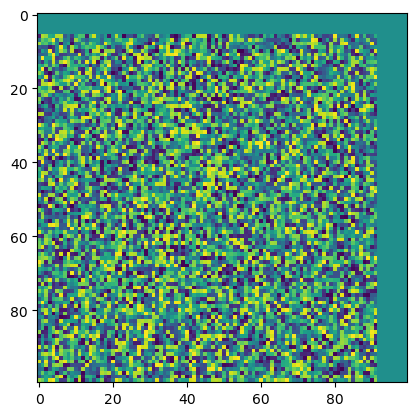

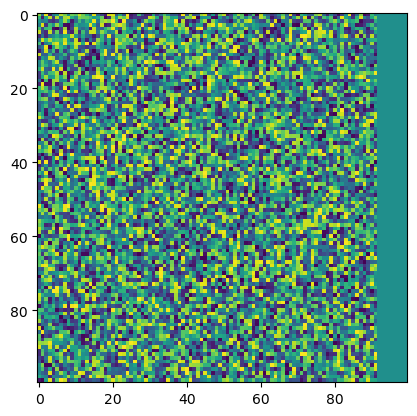

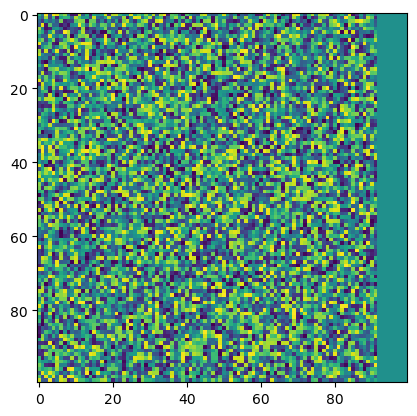

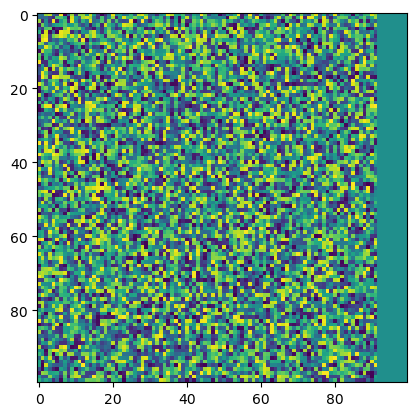

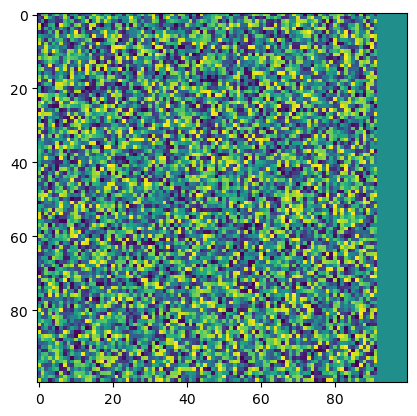

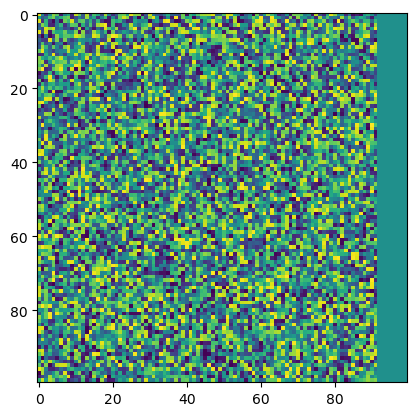

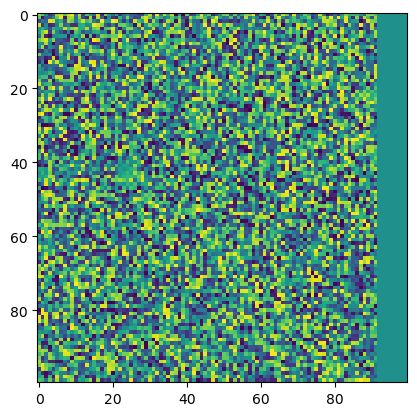

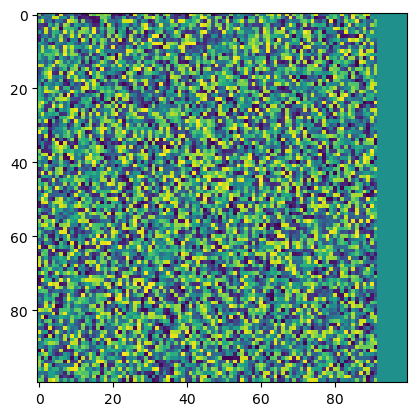

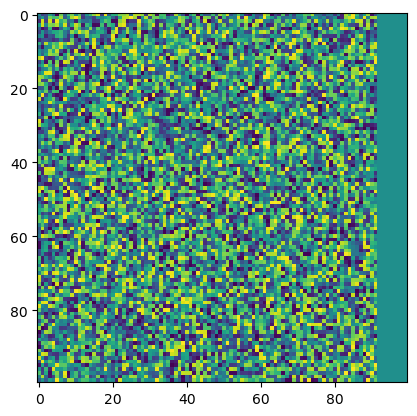

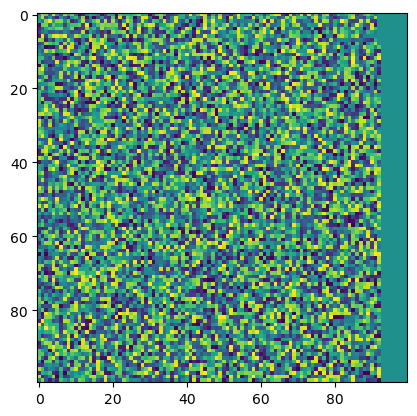

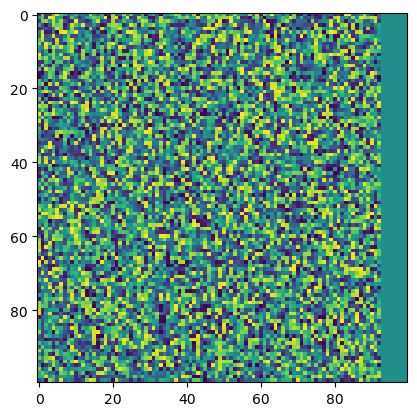

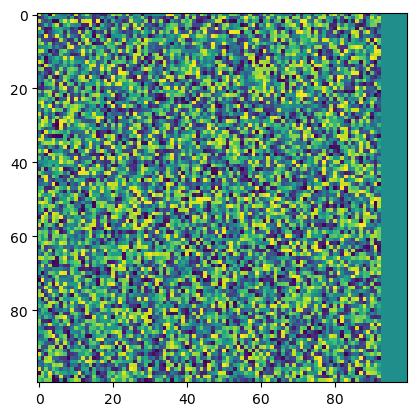

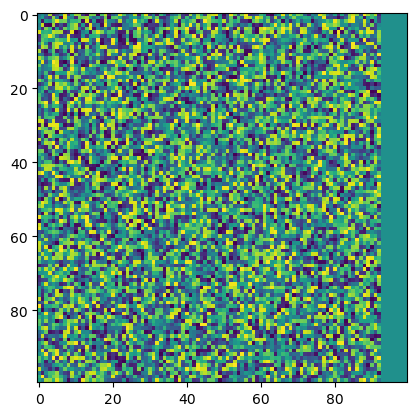

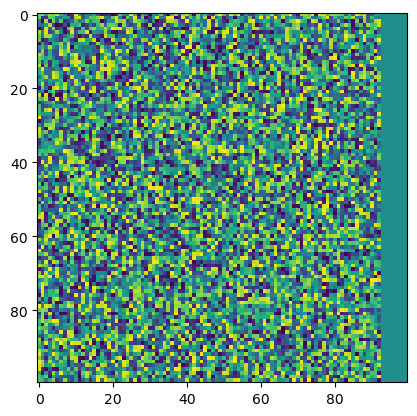

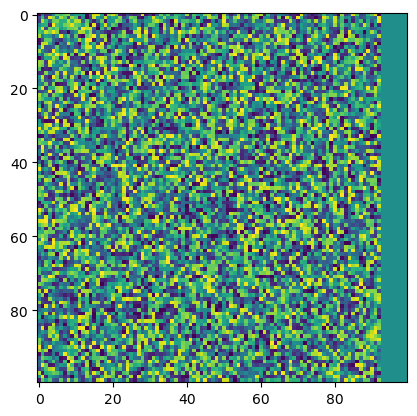

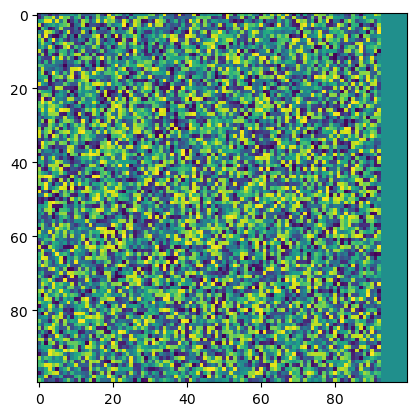

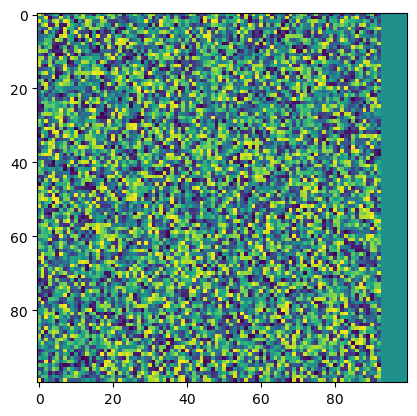

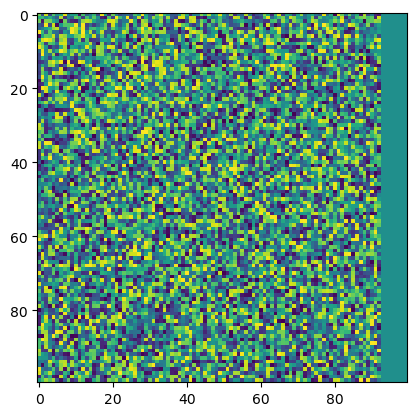

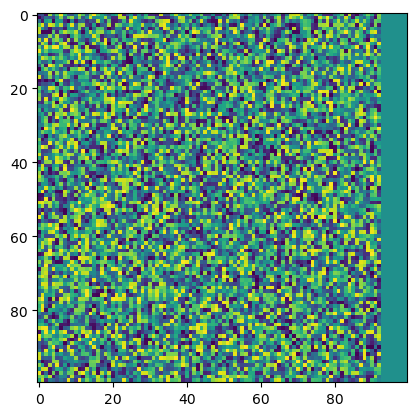

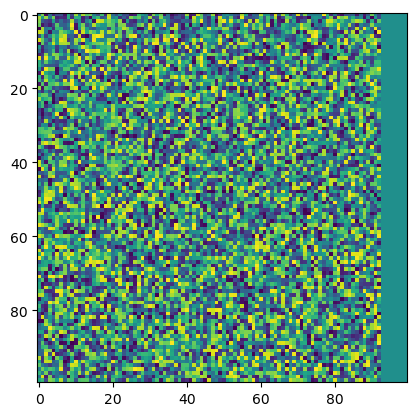

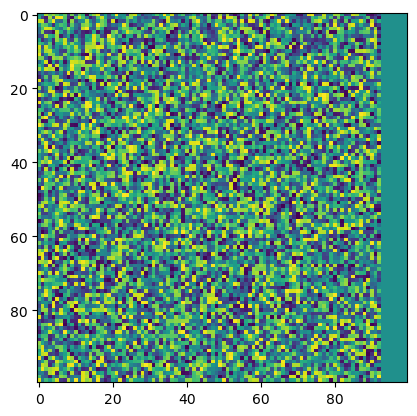

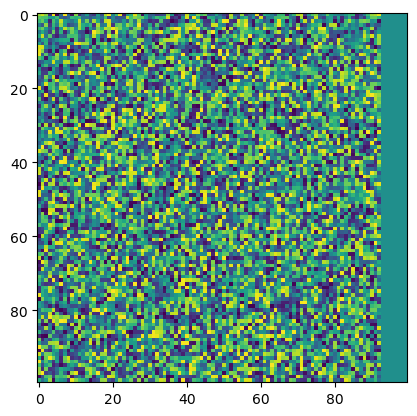

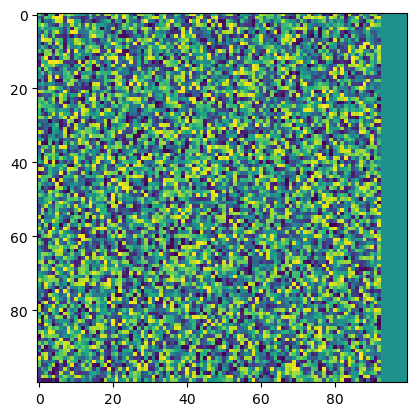

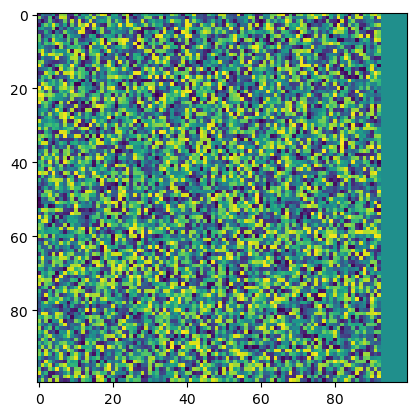

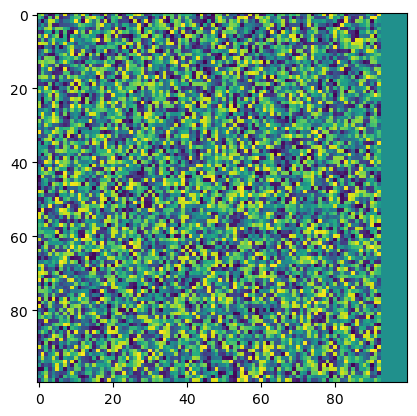

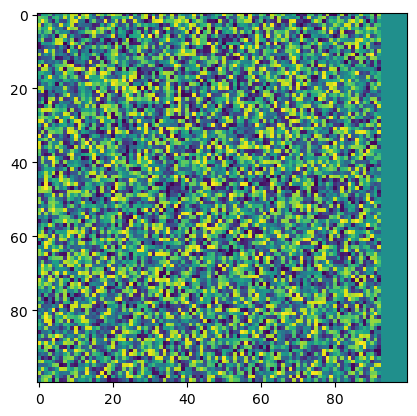

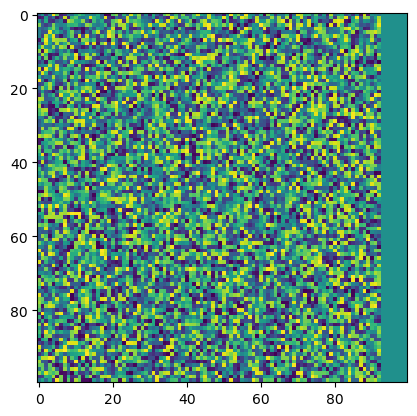

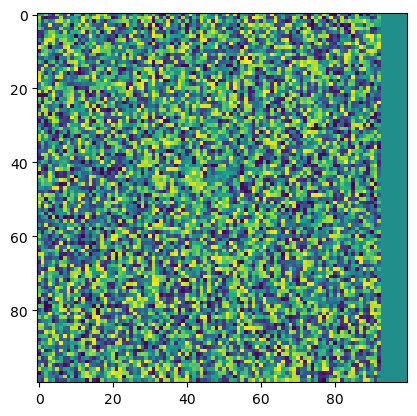

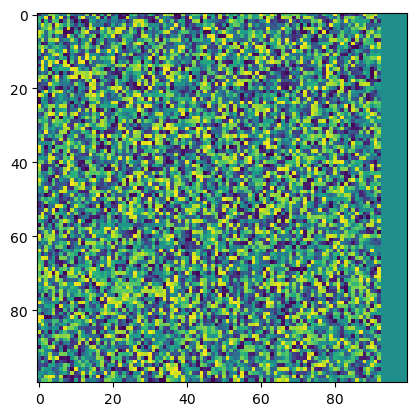

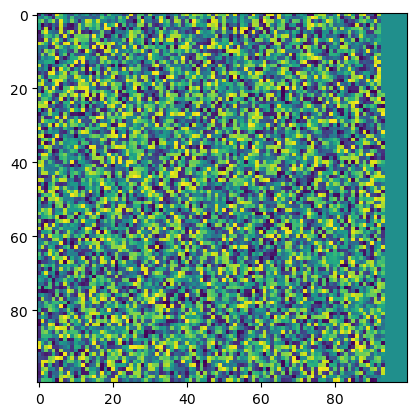

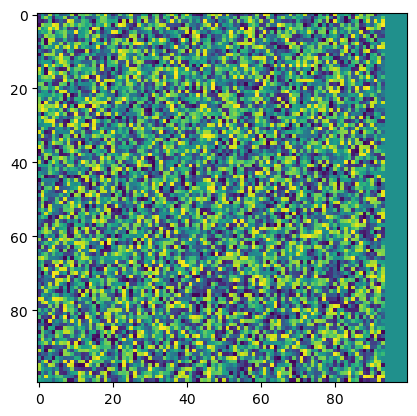

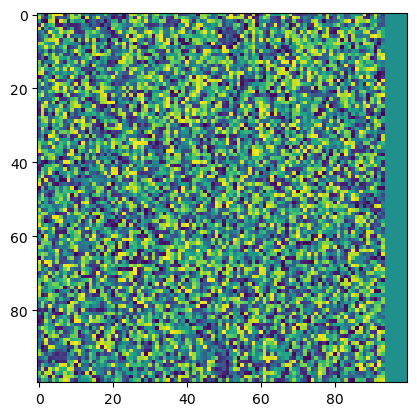

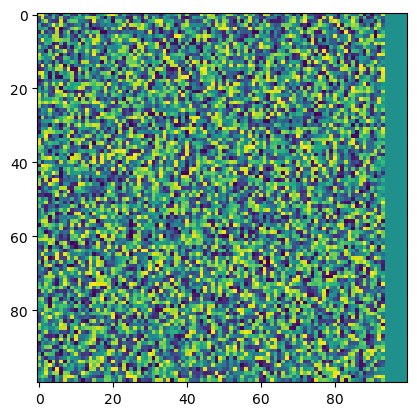

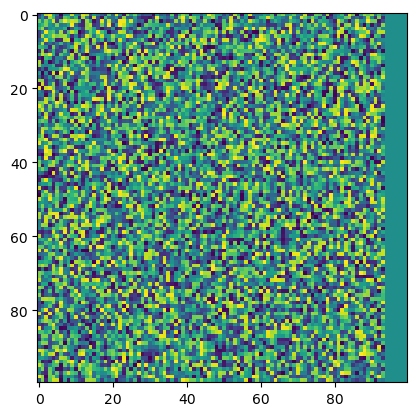

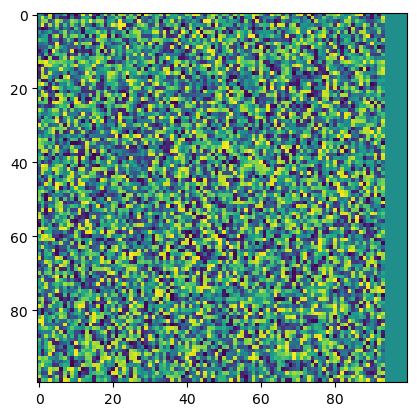

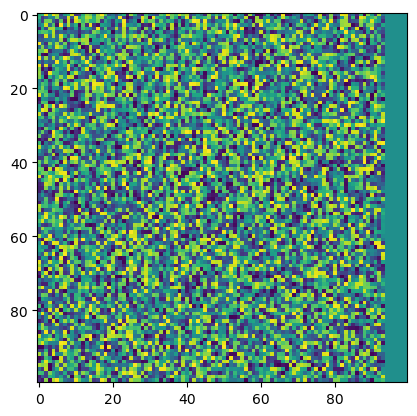

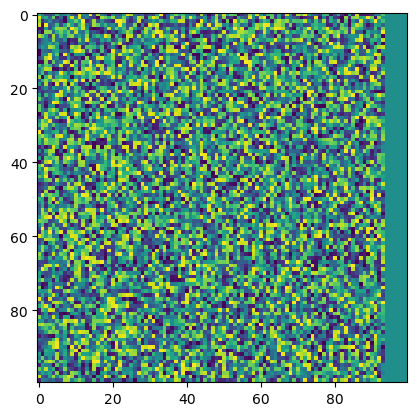

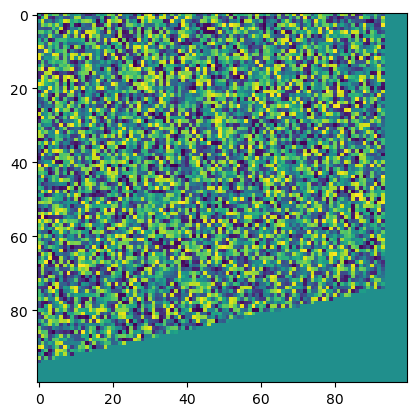

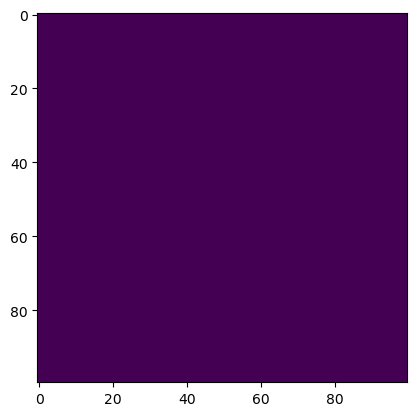

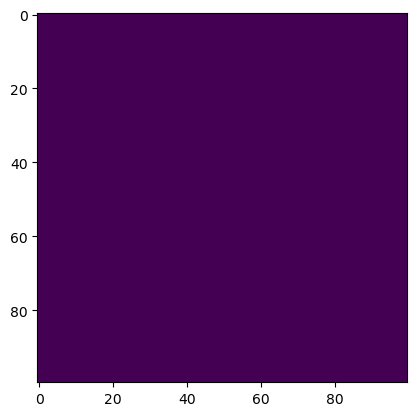

In [24]:
for i in range(0, patches.shape[0]):
    for j in range(0, patches.shape[1]):
        patch1 = patches[i, j, 0]
        patcht=patch1[:,:,0]
        plt.figure(i+1)
        num = i * patches.shape[1] + j
#         print('num', num)
        patch[num, :,:,:]=patch1
        plt.imshow(patcht)
#         plt.close()

        
 
ele1=np.count_nonzero(patch)

In [25]:
ele2=np.count_nonzero(X1)

In [26]:
print('Number of non-zero pixels in divided image stack and full image are', ele1, ele2)

Number of non-zero pixels in divided image stack and full image are 119563014 119563014


In [27]:
patchy = np.zeros((patchesy.shape[0]*patchesy.shape[1],patchesy.shape[2],patchesy.shape[3]))

/tmp/ipykernel_230164/2577988485.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i+1)


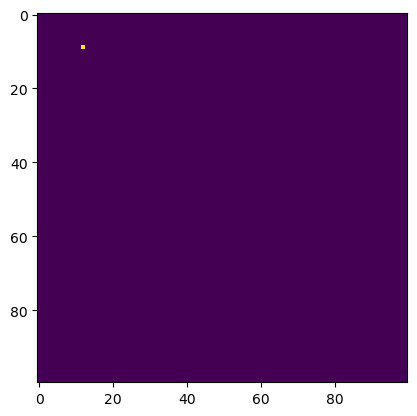

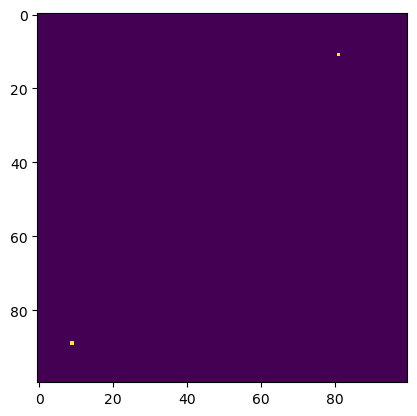

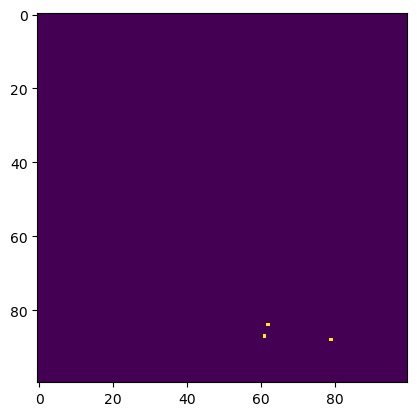

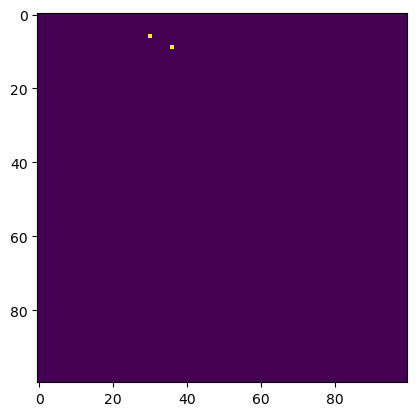

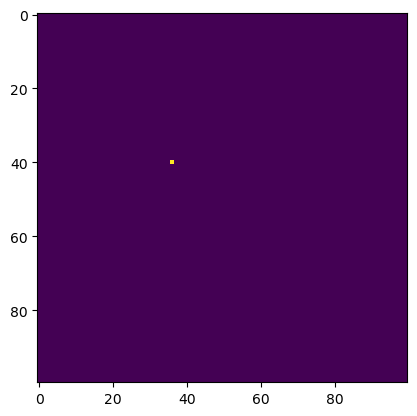

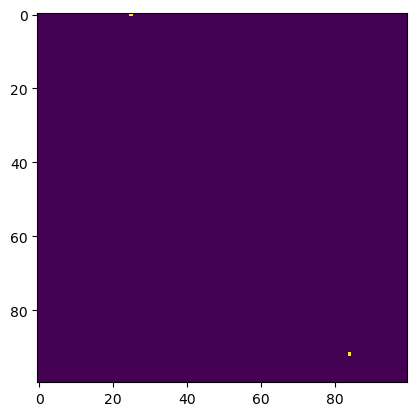

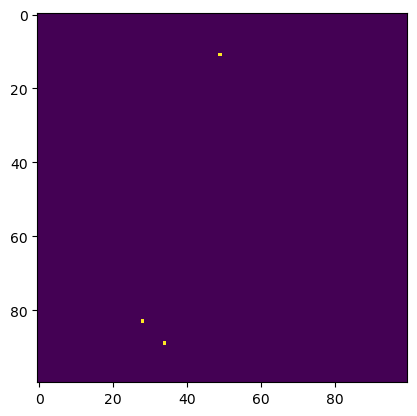

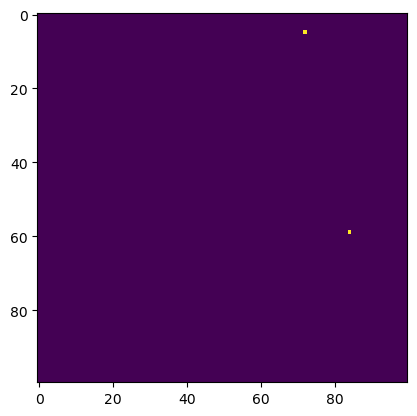

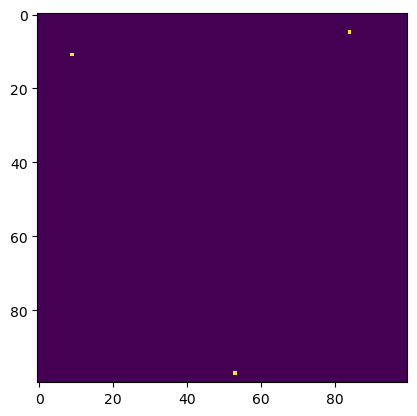

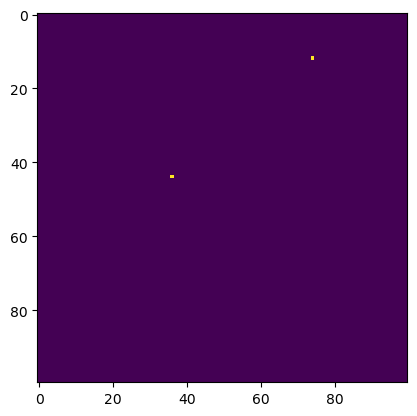

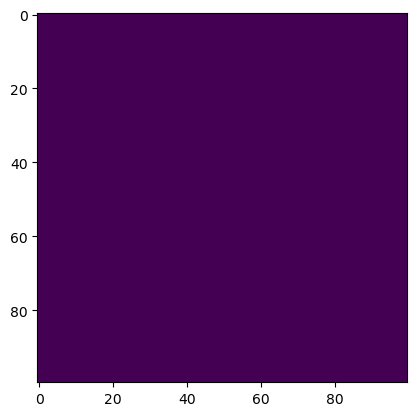

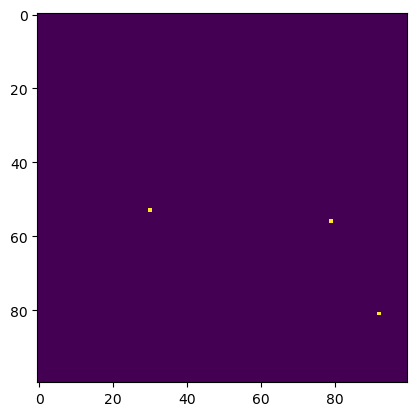

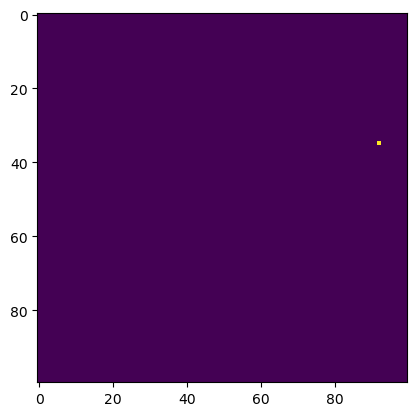

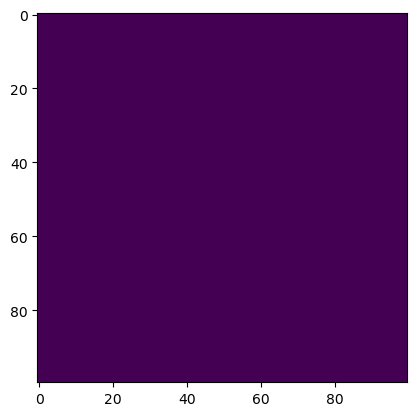

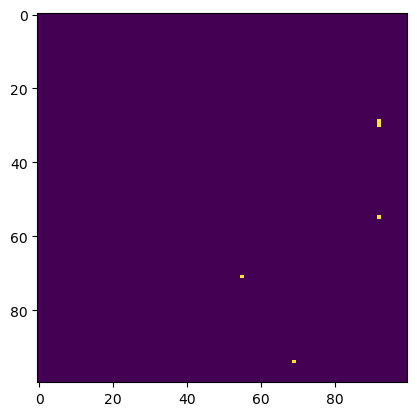

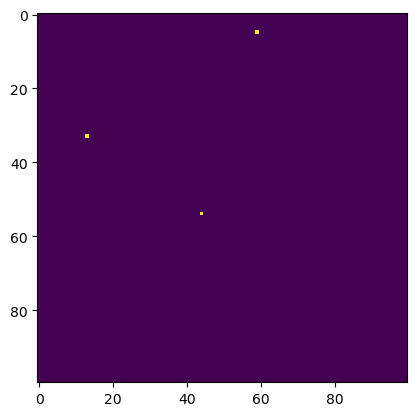

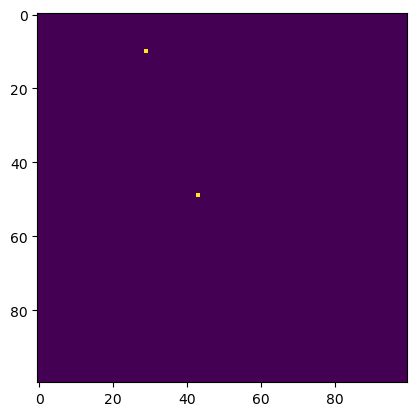

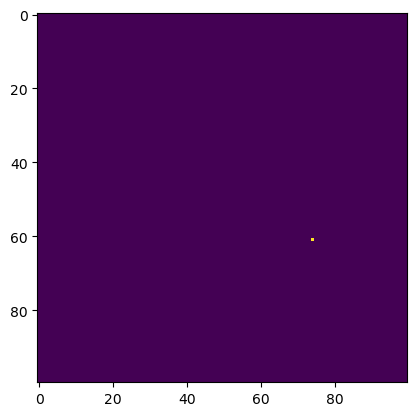

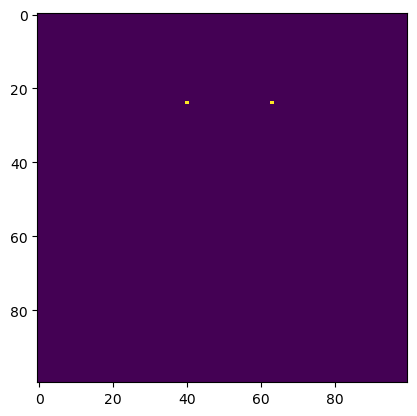

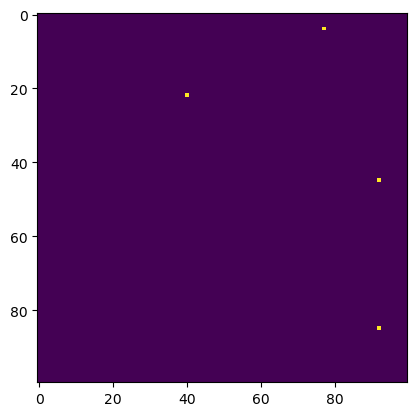

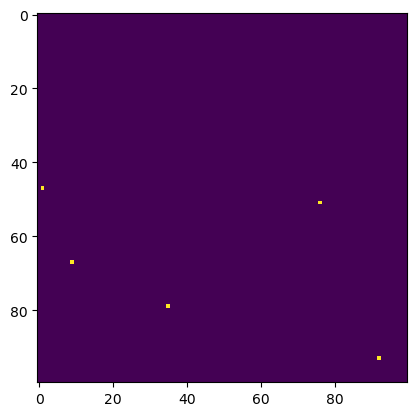

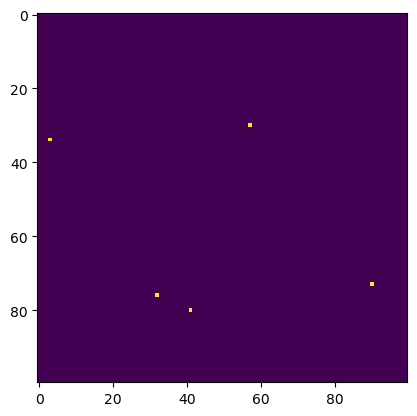

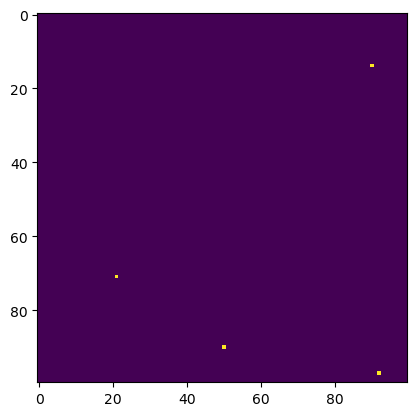

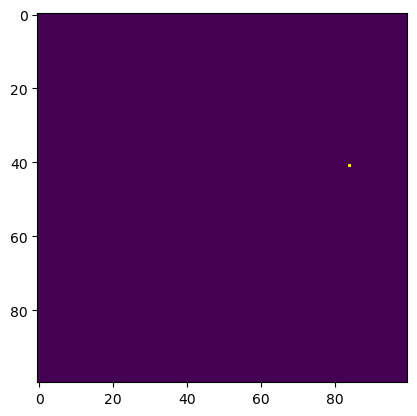

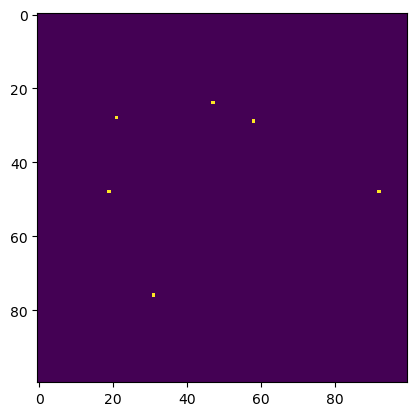

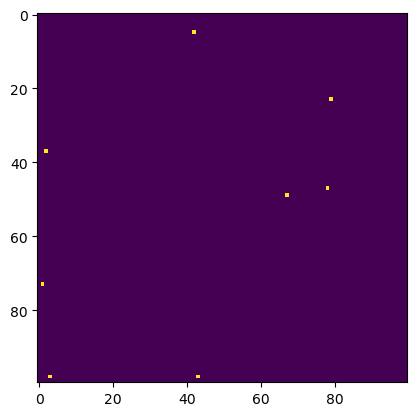

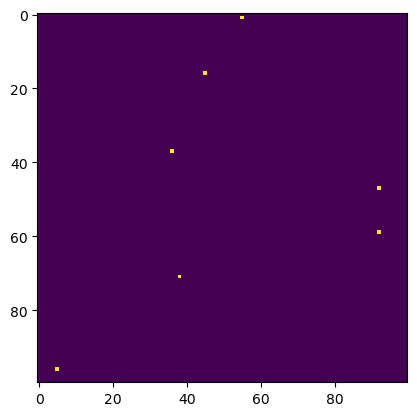

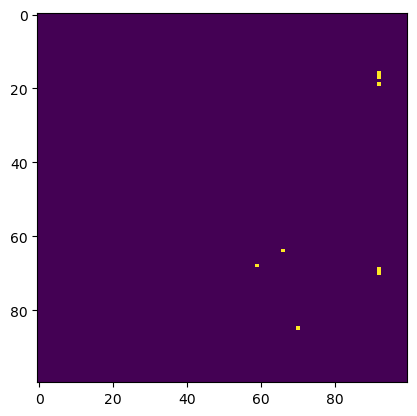

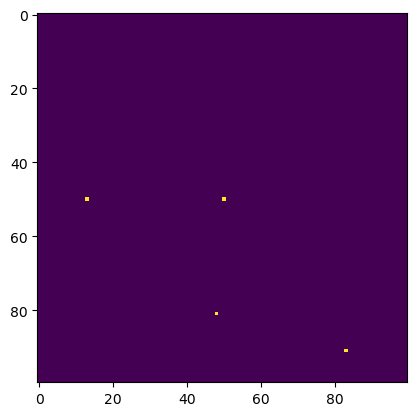

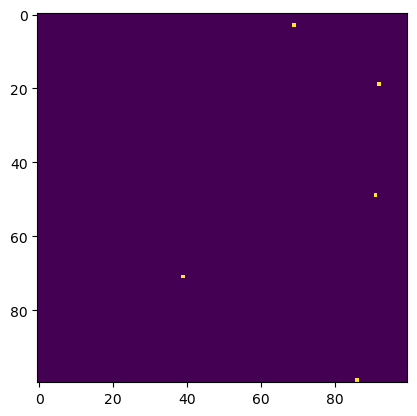

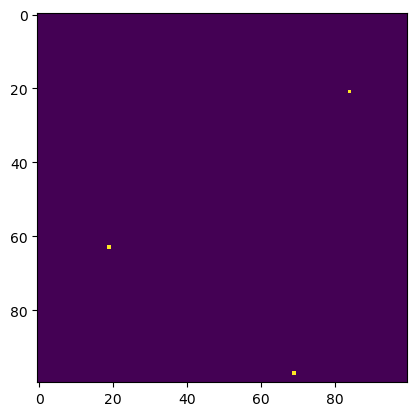

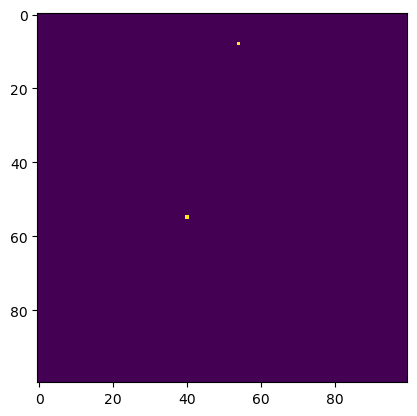

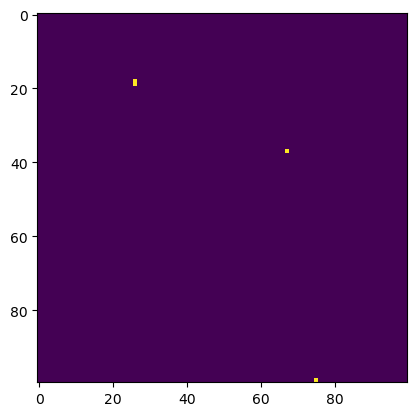

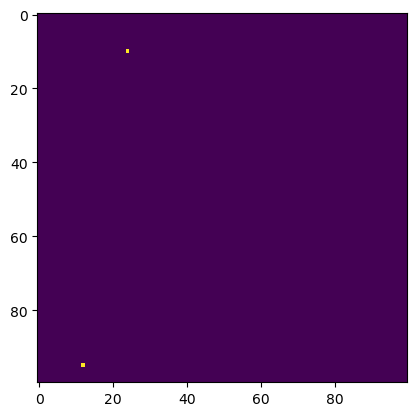

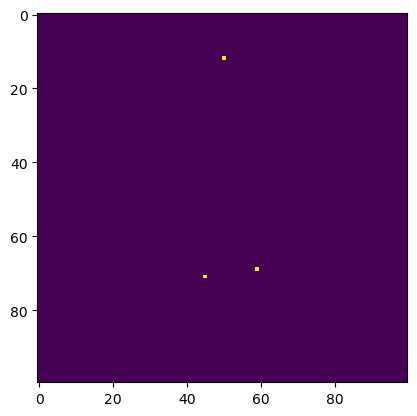

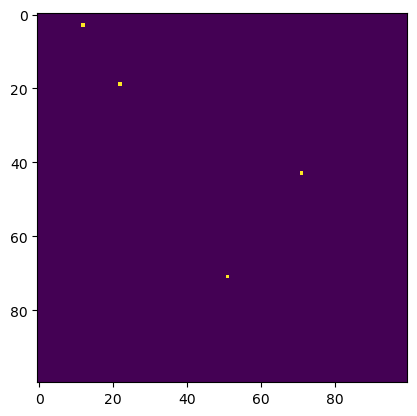

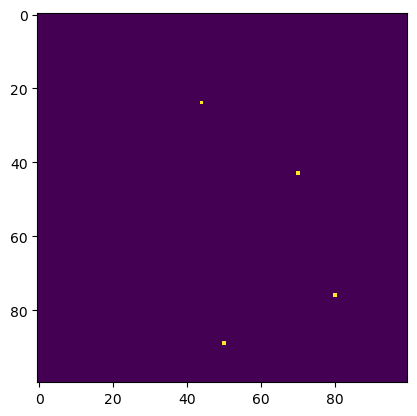

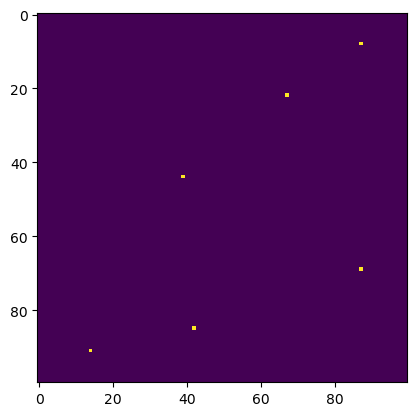

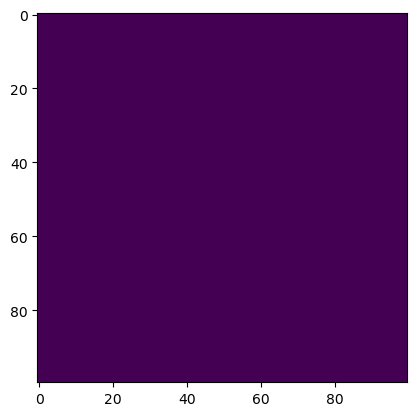

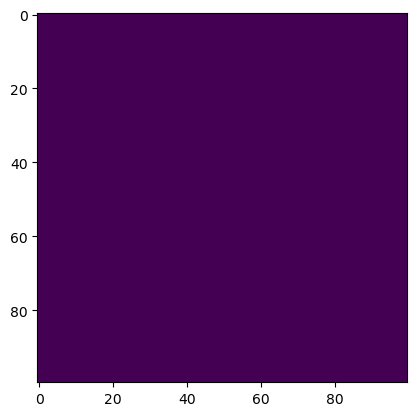

In [28]:
for i in range(patchesy.shape[0]):
    for j in range(patchesy.shape[1]):
        patchy1 = patchesy[i, j, :,:]
        patchyt=patchy1
        plt.figure(i+1)
        numy = i * patches.shape[1] + j
#         print('numy', numy)
        patchy[numy, :,:]=patchy1
        plt.imshow(patchyt)
#         plt.close()

        

In [29]:
ele1=np.count_nonzero(patchy)

In [30]:
ele2=np.count_nonzero(y1)

In [31]:
print('Number of non-zero pixels in divided image stack and full image are', ele1, ele2)

Number of non-zero pixels in divided image stack and full image are 1921838 1921838


In [32]:
input_shape = (img_rows, img_cols, X1.shape[2])

In [33]:
Xdiv=patch

In [34]:
ydiv=patchy

## Dividing training data into train and test data

In [35]:
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [36]:
X_train, X_test, y_train, y_test = train_test_split(Xdiv, ydiv, test_size = 0.2, random_state=32)

In [37]:
X_train=np.moveaxis(X_train,3,1)

In [38]:
X_test=np.moveaxis(X_test,3,1)

### Resizing training and test datasets to size (#samples, #timesteps, img_rows, img_cols,#bands) for convlstm input

In [39]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], img_rows, img_cols,1)

In [41]:
y_train = y_train.reshape(y_train.shape[0], img_rows, img_cols, 1)
y_test = y_test.reshape(y_test.shape[0], img_rows, img_cols, 1)

In [43]:
Xdiv = np.moveaxis(Xdiv,3,1)
Xdiv = Xdiv.reshape(Xdiv.shape[0], Xdiv.shape[1], img_rows, img_cols,1)
ydiv = ydiv.reshape(ydiv.shape[0], img_rows, img_cols, 1)

In [46]:
del dataset # dataset2, X,y

In [47]:
import tensorflow as tf
print("tensorflow keras version:", tf.keras.__version__)
from keras.utils import np_utils
import keras.backend as K
from itertools import product

tensorflow keras version: 2.10.0


## Defining loss functions for the model

In [48]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [49]:
def f1_loss(y_true, y_pred):
    smooth=100
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    f1 = (2 * intersection + smooth) / ( denominator + smooth)
   
    return (1 - f1) * smooth

In [50]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [51]:
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers import LSTM
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization
from keras.layers import AveragePooling3D, Reshape, Activation, Flatten, Dense
from keras import backend as K

In [57]:
batch_size=32
convlstm_model=Sequential()

In [58]:
convlstm_model.add(ConvLSTM2D(filters=16, kernel_size=(2,5), input_shape=(None,img_rows,img_cols,1), padding='same', return_sequences=True, activation='relu'))
convlstm_model.add(LayerNormalization())

In [59]:
convlstm_model.add(ConvLSTM2D(filters=16, kernel_size=(5,5), padding='same', return_sequences=False, activation='relu'))
convlstm_model.add(BatchNormalization())
# clstm_iss.add(LayerNormalization())

In [60]:
convlstm_model.add(Conv2D(filters=16, kernel_size=(11,11), padding='same', activation='relu'))
convlstm_model.add(Dropout(0.4))

In [61]:
convlstm_model.add(Dense(1, activation='sigmoid'))

In [62]:
convlstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 100, 100, 1  10944     
                             6)                                  
                                                                 
 layer_normalization_1 (Laye  (None, None, 100, 100, 1  32       
 rNormalization)             6)                                  
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 100, 100, 16)      51264     
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      30992     
                                                      

In [63]:
from keras.optimizers import SGD, Adam

In [64]:
opt1 = SGD(learning_rate=0.01, decay=1e-4, momentum=0.9, nesterov=True)
opt2 = Adam(learning_rate=0.001, decay=1e-4)
opt3 = Adam(learning_rate=0.01)

In [65]:
convlstm_model.compile(optimizer='adam', loss=f1_loss, metrics=[f1])

In [66]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5)

In [67]:
convlstm_model.fit(X_train, y_train, epochs=20, validation_data=[X_test, y_test], callbacks=early_stopping_monitor)

Epoch 1/20
15/15 [==============================] - 76s 5s/step - loss: 0.2072 - f1: 0.7137 - val_loss: 0.5032 - val_f1: 0.5145
Epoch 2/20
15/15 [==============================] - 69s 5s/step - loss: 0.1087 - f1: 0.8317 - val_loss: 0.1401 - val_f1: 0.8176
Epoch 3/20
15/15 [==============================] - 70s 5s/step - loss: 0.1078 - f1: 0.8225 - val_loss: 0.0941 - val_f1: 0.8520
Epoch 4/20
15/15 [==============================] - 69s 5s/step - loss: 0.0979 - f1: 0.8457 - val_loss: 0.1284 - val_f1: 0.8230
Epoch 5/20
15/15 [==============================] - 69s 5s/step - loss: 0.1009 - f1: 0.8364 - val_loss: 0.1173 - val_f1: 0.8343
Epoch 6/20
15/15 [==============================] - 69s 5s/step - loss: 0.0980 - f1: 0.8417 - val_loss: 0.0835 - val_f1: 0.8635
Epoch 7/20
15/15 [==============================] - 69s 5s/step - loss: 0.0932 - f1: 0.8499 - val_loss: 0.0862 - val_f1: 0.8495
Epoch 8/20
15/15 [==============================] - 69s 5s/step - loss: 0.0913 - f1: 0.8501 - val_loss: 

In [68]:
ypred_test=convlstm_model.predict(X_test)

4/4 [==============================] - 7s 2s/step


In [69]:
ypred_full=convlstm_model.predict(Xdiv)

19/19 [==============================] - 31s 2s/step


In [70]:
ypred_test_class=np.round(ypred_test)   #convert probailities to labels

In [71]:
ypred_full_class=np.round(ypred_full)   #convert probailities to labels for full dataset

In [72]:
Xdiv=patches
image_height=X1.shape[0]
image_width=X1.shape[1]
patch_height=100
patch_width=100
channel_count=X.shape[2]

In [73]:
output_patches=Xdiv
output_shape = (X1.shape[0], X1.shape[1], channel_count)
X_combined = unpatchify(output_patches, output_shape)

In [74]:
ypred_full=ypred_full_class

In [75]:
out_shapey=(y1.shape[0], y1.shape[1])
y_full=ypred_full.reshape(patchesy.shape[0], patchesy.shape[1], img_rows, img_cols)
y_combined=unpatchify(y_full, out_shapey)

In [76]:
y_combined=y_combined.astype(np.uint8)

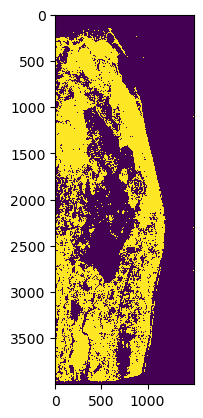

In [77]:
from matplotlib import pyplot as plt
plt.imshow(y_combined, interpolation='nearest')
plt.show()

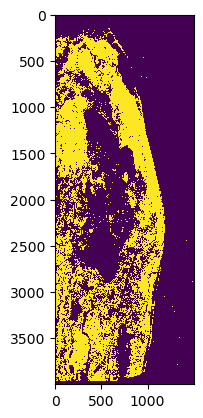

In [78]:
plt.imshow(y1, interpolation='nearest')
plt.show()

In [79]:
import scipy.io as spio

In [80]:
spio.savemat(fpath+'/rs_convlstm_100by100_wabinsar.mat', dict(y1=y1, ypred_test_class=ypred_test_class,
                                                                             ypred_full=ypred_full, ydiv=ydiv, 
                                                                             y_test=y_test, y_train=y_train, 
                                                                             y_combined=y_combined))

### Saving trained model

In [81]:
from keras.models import model_from_json

In [82]:
classifier_json = convlstm_model.to_json()
with open("rs_convlstm_100by100_wabinsar.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5


# Saving trained model weights

convlstm_model.save_weights("rs_convlstm_100by100_wabinsar.tf",save_format='tf')

### Open trained model and associated weights

In [83]:
json_file = open('rs_convlstm_100by100_wabinsar.json', 'r')
loaded_classifier_json = json_file.read()
json_file.close()
loaded_classifier = model_from_json(loaded_classifier_json)
# load weights into new classifier
loaded_classifier.load_weights("rs_convlstm_100by100_wabinsar.tf")
print("Loaded classifier from disk")

Loaded classifier from disk


### Use loaded_classifier.predict(X_pred) to use existing model to predict labels from new dataset X_pred. The dimension of X_pred should also be (#samples, #timesteps, img_rows, img_cols,#bands), where img_rows, img_cols and #bands need to be same as that in the training data.

######################################################################################

## The program gives a map of PS and non-PS pixels. It also gives a model with saved weights that can be further trained on new datasets


Acknowledgements

Conceptualization, input data preparation, validation and funding: Manoochehr Shirzaei

Conceptualization for earlier versions: Avadh Bihari Narayan

Funding support for earlier version: Onkar Dikshit
    